In [1]:
TEST_EXISTING_ARCHITECTURE = False
TEST_STUDENT_ARCHITECTURE = False

In [2]:
####
# Original network adapted from karpathy
# minesh.mathew@gmail.com
# modified version of text generation example in keras;
# trained in a many-to-many fashion using a time distributed dense layer
####

from __future__ import print_function
from sklearn.metrics import confusion_matrix
from IPython.display import display, Image
from time import sleep

from matplotlib import pyplot as plt
from matplotlib import pyplot
import matplotlib as mptl
import pylab

import keras
from keras.models import load_model, Sequential
from keras.layers import Dense, Activation, Dropout, LSTM, CuDNNLSTM, TimeDistributed, Flatten
from keras.utils.data_utils import get_file
from keras.utils import to_categorical, plot_model
from keras.callbacks import EarlyStopping

import numpy as np
import pandas as pd
import random
import time
import sys
import os
import pickle
import gzip
import itertools

Using TensorFlow backend.


In [3]:
# ---------------------- GENERIC UTILITIES --------------------------
def plot_confusion_matrix(cm, class_labels, title="Confusion Matrix", prefix="", cmap=plt.cm.Blues):
    directory = os.path.join(os.getcwd(), "model-performance")
    if not os.path.isdir(directory):
        os.makedirs(directory)
        
    class_count = len(class_labels)
    fig = plt.figure(title)
    fig.set_size_inches(7.5, 6)
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(class_count + 1)
    plt.xticks(tick_marks, class_labels, rotation=45)
    plt.yticks(tick_marks, class_labels)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm = np.around(cm, 2)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

    plt.savefig(os.path.join(directory, prefix + "_confusion_matrix.png"), dpi=100)
    np.set_printoptions(precision=2)
    plt.show(block=False)
    

def graph_history(loss, acc, val_loss, val_acc, plot_val=True, prefix=None):
    # file structure
    directory = os.path.join(os.getcwd(), "model-performance")
    prefix = prefix if prefix is not None else "LSTM_" + "_".join([str(u) for u in lstm_units])
    
    if not os.path.isdir(directory):
        os.makedirs(directory)
    
    # summarize history for accuracy
    fig = plt.figure()
    plt.title("Model Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    
    plt.plot(acc)
    
    if plot_val:
        plt.plot(val_acc)
        plt.legend(["Tr. Acc", "Val. Acc"])

    plt.savefig(os.path.join(directory, prefix + "_history_accuracy.png"), dpi=100)
    plt.show()
 
    # summarize history for loss
    fig = plt.figure()
    plt.title("Model Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    
    plt.plot(loss)

    if plot_val:
        plt.plot(val_loss)
        plt.legend(["Tr. Loss", "Val. Loss"])
    
    plt.savefig(os.path.join(directory, prefix + "_history_loss.png"), dpi=100)
    plt.show()

In [4]:
#-------------------- TEXT FILE PREPROCESSING -----------------

def preprocess_text_file(filename, maxlen=40):
    """load a file and split the text it contains into sequences of length = maxlen
    returns text, chars, char_indices, indices_char, sentences, next_chars
    text: the raw text (turned into lowercase)
    chars: a list of unique characters in the text
    char_indices: a dictionary of the character-to-index conversion
    indices_char: a dictionary of the index-to-character conversion
    sequences: a list of the sequences of max length extracted from the file (stride specified by the step variable below)
    next_chars: a list of the corresponding sequences of max_length next-characters following each of the sequence character members
      in other words, each member of next_chars is contains the last maxlen-1 chars of the correspondiong sequence ...
      and the next character from the text after the last character in that sequence """
    print('loading: ', filename)
    text = open(filename).read().lower()
    print('corpus length:', len(text))
    chars = sorted(list(set(text)))  #returns unique characters from the text
    print('total chars:', len(chars))
    char_indices = dict((c, i) for i, c in enumerate(chars))
    indices_char = dict((i, c) for i, c in enumerate(chars))
    # split the corpus into sequences of length=maxlen
    # input is a sequence of 40 chars and target is also a sequence of 40 chars shifted by one position
    # for eg: if you maxlen=3 and the text corpus is abcdefghi, your input ---> target pairs will be
    # [a,b,c] --> [b,c,d], [b,c,d]--->[c,d,e]....and so on
    step = 1
    sequences = []
    next_chars = []
    #first generate sentences of characters
    for i in range(0, len(text) - maxlen + 1, step):
        sequences.append(text[i: i + maxlen])  # input seq is from i to i  + maxlen
        next_chars.append(text[i + 1:i + 1 + maxlen])  # output seq is from i+1 to i+1+maxlen
        # if i<10 :
        # print (text[i: i + maxlen])
        # print(text[i+1:i +1+ maxlen])
    print('number of sequences:', len(sequences))
    return text, chars, char_indices, indices_char, sequences, next_chars


def save_processed_text(filename, text, chars, char_indices, indices_char, sentences, next_chars ):
    """helper method for saving processed text in a compressed file so that you dont have to preprocess it each time"""
    my_text = [text, chars, char_indices, indices_char, sentences, next_chars] #dont save the one-hot vectors
    with gzip.open(filename, 'wb') as f:  # Python 3: open(..., 'wb')
        pickle.dump(my_text, f)
    # np.savez_compressed(filename,
    #                     text = text,
    #                     chars = chars,
    #                     char_indices=char_indices,
    #                     indices_char=indices_char,
    #                     sentences=sentences,
    #                     next_chars=next_chars)
    #                     # allow_pickle=True, protocol=4)


def load_processed_text(filename):
    """helper method for loading processed text in a compressed file"""
    with gzip.open(filename, 'rb') as f:  # Python 3: open(..., 'rb')
        text, chars, char_indices, indices_char, sentences, next_chars = pickle.load(f)
    # loaded = np.load(filename)
    # text = loaded['text']
    # chars = loaded['chars']
    # char_indices= loaded['char_indices']
    # indices_char= loaded['indices_char']
    # sentences= loaded['sentences']
    # next_chars= loaded['next_chars']
    return text, chars, char_indices, indices_char, sentences, next_chars


def vectorize_text(chars, char_indices, sentences, next_chars, maxlen=40):  #UNUSED: "next_chars"
    """Accepts a list of sentences to convert to indices.  Uses characters, their corresponding indices to produce a set of sequences
    of X and corresponding labels y"""
    # now generate dummy variables (1-hot vectors) for the sequences of characters
    print('Vectorization processing... this could take a while...')
    X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
    y = np.zeros((len(sentences), maxlen, len(chars)),
                 dtype=np.bool)  # y is also a sequence , or  a seq of 1 hot vectors
    joblength = len(sentences)
    tenpercent = joblength/10
    nextpercent = tenpercent
    print(" part 1 of 2")
    for i, sentence in enumerate(sentences):
        if i>nextpercent:
            print(i, " of ", joblength, " completed")
            nextpercent += tenpercent
        for t, char in enumerate(sentence):
            X[i, t, char_indices[char]] = 1  # X has dimension [sentence_count, sentence_length, char_count]
    print(" part 2 of 2")
    nextpercent = tenpercent

    for i, sentence in enumerate(next_chars):
        if i>nextpercent:
            print(i, " of ", joblength, " completed")
            nextpercent += tenpercent
        for t, char in enumerate(sentence):
            y[i, t, char_indices[char]] = 1  # y has dimension [sentence_count, sentence_length, char_count]
    print('vectorization completed')
    return X, y


def generate_text(model, char_indices, indices_char, seed_string="brutus:", generate_character_count=320):
    """Generates text using a model"""
    print("seed string --> ", seed_string)
    print('The generated text is: ')
    sys.stdout.write(seed_string),
    # x=np.zeros((1, len(seed_string), len(chars)))
    for i in range(generate_character_count):
        x = np.zeros((1, len(seed_string), len(chars)))
        for t, char in enumerate(seed_string):
            x[0, t, char_indices[char]] = 1.
        preds = model.predict(x, verbose=0)[0]
        # print (np.argmax(preds[7]))
        next_index = np.argmax(preds[len(seed_string) - 1])

        # next_index=np.argmax(preds[len(seed_string)-11])
        # print (preds.shape)
        # print (preds)
        # next_index = sample(preds, 1) #diversity is 1
        next_char = indices_char[next_index]
        seed_string = seed_string + next_char

        # print (seed_string)
        # print ('##############')
        # if i==40:
        #    print ('####')
        sys.stdout.write(next_char)
    sys.stdout.flush()

In [5]:
# ---------------- MODEL FILE I/O ---------------------------
def save_model(model, save_dir=os.path.join(os.getcwd(), 'saved-models'),
               model_file_name='keras_cifar10_trained_model.h5'):
    """
    Save model and current weights
    :param model: Keras model
    :param save_dir: path name to save directory
    :param model_file_name: filename for saved model
    :return: nothing
    """
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_file_name)
    model.save(model_path)
    print('\nSaved trained model at %s' % model_path)


def load_model(save_dir, model_file_name):
    # Load model and weights
    model_path = os.path.join(save_dir, model_file_name)
    model = keras.models.load_model(model_path)
    print('Loaded trained model from %s ' % model_path)
    return model


# ---------------- MODEL ARCHITECTURE ---------------------------
def build_model(characters):
    # build the model: 2 stacked LSTM
    print('Build model...')
    model = Sequential()
    # model.add(LSTM(512, return_sequences=True, input_shape=(maxlen, len(chars))))  # original one
    #model.add(LSTM(512, input_dim=len(characters), return_sequences=True))  # minesh witout specifying the input_length
    model.add(LSTM(512, return_sequences=True, input_shape=(None,len(characters)) ))  # minesh witout specifying the input_length
    model.add(LSTM(512, return_sequences=True))  # - original
    model.add(Dropout(0.2))
    # model.add(TimeDistributedDense(len(chars)))   #Deprecated TimeDistributedDense
    model.add(TimeDistributed(Dense(len(characters))))  # BJB:  is this really working??
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
    print('model is made')
    # train the model, output generated text after each iteration
    print(model.summary())
    return model


# PROBLEMS TO FIX...
# C:\Users\bborghetti\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: 
#             UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
# C:\Users\bborghetti\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: 
#             UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(512, return_sequences=True, input_shape=(None, 45))`


# ---------------- MODEL TRAINING ---------------------------
def train_net(model, x, y, training_iterations=6, maxlen=40, save_all_model_iterations=True):
    for training_iteration in range(1, training_iterations+1):
        print()
        print('-' * 50)
        print('Training Iteration (epoch) #:', training_iteration)
        history = model.fit(x, y, batch_size=128, epochs=1, verbose=1)    #train 1 epoch at a time using previous weights
        sleep(0.1)  # https://github.com/fchollet/keras/issues/2110

        # saving models at the following iterations -- uncomment it if you want to save weights and load it later
        # if training_iteration==1 or training_iteration==3 or training_iteration==5 or training_iteration==10 or training_iteration==20 or training_iteration==30 or training_iteration==50 or training_iteration==60 :

        # # save every training_iteration of weights
        # model.save_weights('Karpathy_LSTM_weights_' + str(training_iteration) + '.h5', overwrite=True)
        # start_index = random.randint(0, len(text) - maxlen - 1)
        save_dir = os.path.join(os.getcwd(), 'saved-models')
        current_model_file_name = 'LSTM_model_' + str(training_iteration) + '.h5'
        if save_all_model_iterations:
            save_model(model=model, save_dir=save_dir, model_file_name=current_model_file_name)
        sys.stdout.flush()
        print('loss is')
        print(history.history['loss'][0])
        print(history)
        print()
    return model


# ---------------- MODEL EVALUATION ---------------------------
# def test_model(model, observations, targets):
#     '''
#     STUDENT SHOULD WRITE THIS CODE
#     :param model: a trained RNN model which accepts a sequence and outputs a target class (0;1;2;3)
#     :param observations: a list of 40-character sequences to classify
#     :param targets: a list of the true classes of the 40-character sequences
#     :return: a sklearn confusion matrix
#     '''
#     #< put student code here to test the model >
#     actual_class_IDs = []
#     predicted_class_IDs = []
#     # generate & print confusion matrix to screen
#     cm = confusion_matrix(actual_class_IDs, predicted_class_IDs)
#     return cm

# Step 0: Conduct a training check on the existing architecture

Using the provided code, practice training and testing the Karpathy model on each of the provided text samples dataset on a small number of epochs (e.g. 5 to 10). The number of training epochs required to get to a certain loss value will probably go down as the amount of available training text goes up. Use `generate_text()` to try some text generation with the fully trained model. The default setting for model training will save versions of the model after each training epoch. By exploring the output of models trained with different numbers epochs you will notice the evolution of what your model “knows.” Models trained on few epochs babble. Those trained on too-many epochs will plagiarize whole chunks of the source text. Somewhere in the middle, the model will appear to get the “gist” of the training text - it writes in the "style" of the author without appearing to plagiarize.

In [6]:
################################################################
#--------------------- Main Code -----------------------------

if TEST_EXISTING_ARCHITECTURE:
    # pick the filename you want to use, and comment out the rest
    # make sure you have this directory structure
    # QUICK CHECK w/SMALL TEXT
    raw_text_filename='./textdatasets/tinytesttext.txt'
    # CLASS DATASETS BELOW
    # raw_text_filename='./textdatasets/0_bible.txt'
    # raw_text_filename='./textdatasets/1_nietzsche.txt'
    # raw_text_filename='./textdatasets/2_shakespeare.txt'
    # raw_text_filename='./textdatasets/3_warpeace.txt'

    processed_filename = raw_text_filename+'.pklz'  # save process will append a .pklz on the filename

    #set the boolean below to true to double check the save file is working
    TEST_SAVE_LOAD_EQUAL = True

    if TEST_SAVE_LOAD_EQUAL:
        text, chars, char_indices, indices_char, sentences, next_chars \
            = preprocess_text_file(raw_text_filename)
        save_processed_text(processed_filename, text, chars, char_indices, indices_char, sentences, next_chars)
        _text, _chars, _char_indices, _indices_char, _sentences, _next_chars = load_processed_text(processed_filename)
        print("Testing equivalences of preprocessed and  saved-preprocessed text (6 checks)")
        print("  text equal: ",np.array_equal(_text, text))
        print("  chars equal: ",np.array_equal(_chars, chars))
        print("  char_indices equal: ",np.array_equal(_char_indices, char_indices))
        print("  indices_chars equal: ",np.array_equal(_indices_char, indices_char))
        print("  sentences equal: ",np.array_equal(_sentences, sentences))
        print("  next_chars equal: ",np.array_equal(_next_chars, next_chars))
        print("Testing vectorization")
        X, y = vectorize_text(_chars, _char_indices, _sentences, _next_chars)
        print("Vectorization test complete")


    PROCESS_RAW_TEXT = True  #set to True to process a previously unseen textfile - otherwise load a preprocessed file

    if PROCESS_RAW_TEXT:
        text, chars, char_indices, indices_char, sentences, next_chars \
            = preprocess_text_file(raw_text_filename)
        save_processed_text(processed_filename, text, chars, char_indices, indices_char, sentences, next_chars)
    else:  # instead, load previously processed text
        text, chars, char_indices, indices_char, sentences, next_chars = load_processed_text(processed_filename)

    #vectorized form takes too much space to save... so process in real time
    X, y = vectorize_text(chars, char_indices, sentences, next_chars)

    TRAIN_MODE = True   #SET TO FALSE BEFORE SUBMITTING YOUR ASSIGNMENT!!!

    if TRAIN_MODE:
        model = build_model(characters=chars)
        model_epoch_training_iterations = 20    #the bigger your text corpus, the smaller you can make this
        model = train_net(model=model, x=X, y=y,
                          training_iterations=model_epoch_training_iterations,
                          save_all_model_iterations=True)
    else:  # load a model from a file
        # decide which iteration of the trained model you want to explore
        model_training_iteration = 1
        save_dir = os.path.join(os.getcwd(), 'saved-models')
        current_model_file_name = 'LSTM_model_' + str(model_training_iteration) + '.h5'
        model = load_model(save_dir=save_dir, model_file_name=current_model_file_name)

    GENERATE_TEXT_MODE = True

    if GENERATE_TEXT_MODE:   # generate text mode
        #decide which saved model to load
        #make up a string of characters to start with
        seed_string = "certainly"
        # decide how many text characters you want to generate:
        gen_char_count = 200
        generate_text(model, char_indices, indices_char, seed_string, generate_character_count=gen_char_count)

In [7]:
if TEST_EXISTING_ARCHITECTURE:
    for i in range(20):
        print("\n\nEpoch #{}/20 -----".format(i + 1))
        # decide which iteration of the trained model you want to explore
        model_training_iteration = i + 1
        save_dir = os.path.join(os.getcwd(), 'saved-models')
        current_model_file_name = 'LSTM_model_' + str(model_training_iteration) + '.h5'
        model = load_model(save_dir=save_dir, model_file_name=current_model_file_name)

        #make up a string of characters to start with
        seed_string = "certainly"
        # decide how many text characters you want to generate:
        gen_char_count = 200
        generate_text(model, char_indices, indices_char, seed_string, generate_character_count=gen_char_count)

I trained the model on the test file, `tinytesttext.txt`, for 20 epochs. For each version of the trained model, I generated 200 characters. The file `existing-architecture-output.txt` contains the output of the text generation.

I tested this archicture on my non-GPU computer (I did not have access to my GPU computer when I started this assignment). Training epochs for the other files were simply too long to run on this computer, so I deemed this simple test sufficient.

# Step 2: Design customized code to generate training / validation / test data

Modify the existing training code to match your assigned task (inputs are character sequences and outputs are class IDs). You will need to figure out how to read and vectorize each of the four text files and use them all to train your network. You will also need to split the data into train (40%) / validation (40%) / test (20%) samples. Do this in a way such that

- The order of any characters in text is preserved, 
- That none of the characters in any n-character sequence are used in more than one partition of the train/val/test split 
- The text for each partition is interleaved so that all portions of the text are represented in each of the partitions (in other words, DON’T just cut the text by location in the file into beginning = training, middle = validation, end = test).  
- The same amount of data from each class for training / validation. Note that the text files for each class are different sizes, so be careful how you implement this. You will need to use less than the full amount of text from each file.

Assuming that the sequence length `n = 40`, one way to do this split might be to chunk the text file into a sequence of 400-character segments (ignoring the final segment of less than 400 characters in the file) and then partition these segments into train, val, and test such that the first 160 chars are used for training, the second 160 chars are used for validation, and the last 80 chars are used for test. Then, within each group, use vectorize_text to parse the text into sub-strings, and recombine the substrings into full sets for train / val / test sets. Also, make sure that you do this segmentation with respect for the classes where the text came from. A final caution:  don’t use off-the-shelf train-val-test splitters available in other packages unless you first ensure they meet all of the requirements expressed in this step… and document how they achieve this. If you build your own code for this part, fully document how you did it in your report.

### Design documentation

I built my own code for this step. My sequence-generation process relies on three functions: `process()`, `vectorize()`, and the main function, `generate_train_val_test()`.

`process()` receives a filename, a class ID for the file, and a chunk length `n`. The function converts all text in the file to lowercase and copies it to a string. It then splits this string into chunks of length `n` (the function ignores the last chunk if said chunk has fewer than `n` characters). Finally, the function returns a list of these chunks and their associated class IDs, and it also returns a set of all unique characters in the file.

`vectorize()` receives a list of unique characters, a dictionary mapping each of these characters to an index, and a sequence length `n`. The function also receives a list of sentences, where each sentence in the list contains a string of length `n` and a class ID. The function creates a 3D NumPy array full of `False` values. The dimensions of this array correspond to the number of sentences, `n`, and the number of unique characters. The function loops over every character in every sentence and sets the cell corresponding to that character to `True`. Thus, the function builds a one-hot encoding of the sentences. It then grabs every class ID in the list of sentences and uses `keras.utils.to_categorical` to build a one-hot encoding of the IDs. Finally, the function returns the two one-hot encodings, which of course represent input (`x`) and output (`y`).

`generate_train_val_test()` receives a dictionary of files, where the key is the file's class ID and the value is the file's actual filename, and a sequence length `n`. Then, the function follows this process:

1. Define a chunk length of `10 * n`
2. For each file in the dictionary, `process()` the file; concatenate the returned sets of chunks and characters into two large arrays (`all_chunks` and `all_chars`)
3. Remove duplicates from `all_chars` and then sort the list. Additionally, build a dictionary of these characters, where the key is the character itself and the value is the index of the character in the sorted list
4. Define three empty lists, one for each of the training, validation, and testing sets
5. For each chunk,
    1. Take the first 40%. Then, add every sequential `n` characters (and the associated class ID) to the training set
    2. Take the second 40%. Then, add every sequential `n` characters (and the associated class ID) to the validation set
    3. Take the final 20%. Then, add every sequential `n` characters (and the associated class ID) to the testing set
6. Randomly select `n` elements for each class from the training, validation, and testing sets. In this case, `n` is the size of the smallest class in each set. In other words, randomly sample the classes in each set to balance the classes in the three sets
7. `vectorize()` the training, validation, and testing sets
8. Return the vectorized training, validation, and testing input/output sets. Additionally, return the list of unique characters and the character dictionary

In [8]:
# loads and processes a text file
def process(filename, class_id, chunk_length=400):
    # load the file
    filename = os.path.join(os.getcwd(), "textdatasets", filename)
    print("Loading:", filename, end="\n\n")
    text = open(filename).read().lower()
    
    # get the text's unique characters
    chars = list(set(text))
    
    # split text into chunks
    chunks = np.array([text[i:i + chunk_length] for i in range(0, len(text) - chunk_length, chunk_length)])
    
    # output stats
    print("\tNum chunks    :", len(chunks))
    print("\tCorpus length :", len(text))
    print("\tUnique chars  :", len(chars), end="\n\n")
    
    return chars, chunks

In [9]:
# converts a list of sentences into a list of one-hot vectors
def vectorize(sentences, chars, chars_indices, seq_length):
    # one-hot output variables
    y = to_categorical(np.array([sentence[1] for sentence in sentences]))
    
    # one-hot input variables
    x = np.zeros((len(sentences), seq_length, len(chars)), dtype=np.bool)
    
    # for each sentence...
    for i, sentence in enumerate([sentence[0] for sentence in sentences]):
        # for each character...
        for j, char in enumerate(sentence):
            x[i, j, chars_indices[char]] = 1
    
    return x, y

In [10]:
# generates training/validation/test sets using all available files
def generate_train_val_test(files, seq_length=40):
    # how long does this take?
    start = time.time()
    
    # chunk length for the full text file
    chunk_length = seq_length * 10
    
    # we'll need these
    all_chunks = []
    all_chars = []
    
    # for each file...
    for key in files:
        chars, chunks = process(files[key], key, chunk_length)
        all_chunks.append(chunks)
        all_chars.extend(chars)
    
    # get the unique characters from all texts and build a character dictionary
    all_chars = sorted(list(set(all_chars)))
    chars_indices = dict((c, i) for i, c in enumerate(all_chars))
    
    # train/val/test set limits
    train_end = int(0.4 * chunk_length)
    test_start = int(0.8 * chunk_length)
    
    # we'll need these
    datasets = {}
    min_train = np.inf
    min_val = np.inf
    min_test = np.inf
        
    # for each set of chunks...
    for key, chunks in enumerate(all_chunks):
        # we'll need these
        train = []
        val = []
        test = []
        
        # chunk --> train_x --> sequences of length = seq_length
        for chunk in [chunk[:train_end] for chunk in chunks]:
            for i in range(0, len(chunk) - seq_length + 1):
                train.append([chunk[i:i + seq_length], key])
        
        # chunk --> val_x --> sequences of length = seq_length
        for chunk in [chunk[train_end:test_start] for chunk in chunks]:
            for i in range(0, len(chunk) - seq_length + 1):
                val.append([chunk[i:i + seq_length], key])

        # chunk --> test_x --> sequences of length = seq_length
        for chunk in [chunk[test_start:] for chunk in chunks]:
            for i in range(0, len(chunk) - seq_length + 1):
                test.append([chunk[i:i + seq_length], key])
        
        # add subsets to the full set
        datasets[key] = {"train": np.array(train), "val": np.array(val), "test": np.array(test)} 
        
        # update minimum sizes
        min_train = min(min_train, len(train))
        min_val = min(min_val, len(val))
        min_test = min(min_test, len(test))
        
    # selectively sample <min> elements from every set
    for key in datasets:
        # select random indices
        train_idx = np.random.choice(len(datasets[key]["train"]), min_train)
        val_idx = np.random.choice(len(datasets[key]["val"]), min_val)
        test_idx = np.random.choice(len(datasets[key]["test"]), min_test)
        
        # filter train/val/test sets using selected indices
        datasets[key]["train"] = datasets[key]["train"][train_idx]
        datasets[key]["val"] = datasets[key]["val"][val_idx]
        datasets[key]["test"] = datasets[key]["test"][test_idx]
    
    # join the subsets for all files
    train = np.concatenate([datasets[key]["train"] for key in datasets.keys()])
    val = np.concatenate([datasets[key]["val"] for key in datasets.keys()])
    test = np.concatenate([datasets[key]["test"] for key in datasets.keys()])
    
    # vectorize the sets
    train_x, train_y = vectorize(train, all_chars, chars_indices, seq_length)
    val_x, val_y = vectorize(val, all_chars, chars_indices, seq_length)
    test_x, test_y = vectorize(test, all_chars, chars_indices, seq_length)
    
    print("Generated training, validation, and test sets in {:.2f} seconds".format(time.time() - start))
    return train_x, train_y, val_x, val_y, test_x, test_y, all_chars, chars_indices

In [11]:
files = {
    0: "0_bible.txt",
    1: "1_nietzsche.txt",
    2: "2_shakespeare.txt",
    3: "3_warpeace.txt"
}

seq_length = 40
train_x, train_y, val_x, val_y, test_x, test_y, all_chars, chars_indices = generate_train_val_test(files=files, seq_length=seq_length)

Loading: C:\Users\David\iCloudDrive\Documents\masters\summer19\deep learning\assignments\homework 4\textdatasets\0_bible.txt

	Num chunks    : 10831
	Corpus length : 4332559
	Unique chars  : 49

Loading: C:\Users\David\iCloudDrive\Documents\masters\summer19\deep learning\assignments\homework 4\textdatasets\1_nietzsche.txt

	Num chunks    : 1502
	Corpus length : 600901
	Unique chars  : 59

Loading: C:\Users\David\iCloudDrive\Documents\masters\summer19\deep learning\assignments\homework 4\textdatasets\2_shakespeare.txt

	Num chunks    : 11433
	Corpus length : 4573338
	Unique chars  : 41

Loading: C:\Users\David\iCloudDrive\Documents\masters\summer19\deep learning\assignments\homework 4\textdatasets\3_warpeace.txt

	Num chunks    : 7990
	Corpus length : 3196232
	Unique chars  : 60

Generated training, validation, and test sets in 29.08 seconds


# Step 1: Student architecture design

Your goal in this step is to design and document your proposed model.

**Note:** I'm not sure how Steps 1a and 1c differ, so I've combined the two.

### Step 1a: Design and implement the model

Your model has a different ML task than Karpathy’s – you need to determine from which text a sequence of characters most likely came from. Your input observation will be a string of text (40 characters) drawn from the training text. Your output will be a class ID (*0_bible.txt*; *1_nietzsche.text*; *2_shakespeare.txt*; *3_warpeace.txt*). You can provide a class ID for each character in the input sequence, but you must provide an overall class ID (`0`, `1`, `2`, or `3`) for the whole input sequence. You could use one-hot encoding here.

In [12]:
def build_student_model(lstm_units=[100], dropout=0.2, input_shape=(seq_length, len(all_chars)), prefix=None):
    model = Sequential()
    
    # first block
    model.add(CuDNNLSTM(lstm_units[0], input_shape=input_shape, return_sequences=True))
    model.add(Dropout(dropout))
    
    # remaining blocks (if such blocks exist)
    for units in lstm_units[1:]:
        model.add(CuDNNLSTM(units, return_sequences=True))
        model.add(Dropout(dropout))
    
    # final layers
    model.add(Flatten())
    model.add(Dense(len(files), activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    # we'll save the model diagrams here
    path = "model-diagrams"
    
    # file prefix
    prefix = prefix if prefix is not None else "LSTM_" + "_".join([str(u) for u in lstm_units])

    if not os.path.isdir(path):
        os.makedirs(path)

    # plot and show the model diagram
    path = os.path.join(path, prefix + "_model_diagram.png")
    plot_model(model, to_file=path, show_shapes=True, show_layer_names=True)
    display(Image(filename=path, width=400))
    
    return model, lstm_units

The function `build_student_model` allows for some user-level model configuration. The model accepts two primary parameters:

1. `lstm_units`, a list of the desired size(s) for at least one LSTM layer
2. `dropout`, which represents the desired dropout rate for the dropout layer(s)

The function constructs a neural network. Specifically, it creates a sequential model and then adds some number of LSTM blocks, a flatten layer, and a dense layer. The number of and parameters for the LSTM blocks are user-configurable; the rest of the architecture is provided as-is.

Each LSTM block consists of one LSTM layer (with a user-defined number of units) and a dropout layer (with a user-defined dropout rate). The user can define any number of LSTM layers of any number of units; however every dropout layer uses the same dropout rate.

The dense layer has four units (for this set of files) and uses a softmax activation function for classification. I compile each model with a categorical cross-entropy loss function and an Adam optimizer.

To decrease execution time, I use the CuDNNLSTM layer (as opposed to a standard LSTM) because it optimizes training and evaluation for the GPU.

 ### Step 1b: Document the design
 
Examine the layers of your model in the code, and develop a diagram (e.g. using Keras functions and/or PowerPoint) of the layers like you’ve seen in class or on the internet. In text, describe the architecture and its parameterization. Discuss: How many parameters are there in your whole model? In each layer? How did you decide on overall size/capacity? What other features are present in your model (like dropout) and why did you use them? How does your model differ from the Karpathy-like model?  

---

I did not make any obvious decisions for model size/capacity. Because the model is user-configurable, I am able to iterate over several different architectures. This leads to improved performance because we are not restricted to one single architecture.

The generic model is a bit different from the Karpathy-like model (KM). Specifically, KM uses two large LSTM layers, both of 512 units, but my model defaults to one small-ish LSTM layer of 100 units. Of course, the user can choose exactly how many layers to use and how large to make the layers.

Additionally, KM uses one dropout layer of 20%. My model is different in that it uses one dropout layer after every LSTM layer. These models tend to overfit after just a few epochs, so I think the extra dropout layers (for models with at least two LSTM layers) can improve model performance by preventing overfitting.

Furthermore, KM uses a time-distributed wrapper for its dense layer. Our problem task is classification, so we probably don't need to do this.

Finally, KM uses RMSprop as its optimizer. I'm sure this is fine, but I use Adam because I'm more familiar with it. Given ample time and resources, I would allow the user to decide on the optimizer (among other model features) and then iterate over several choices.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


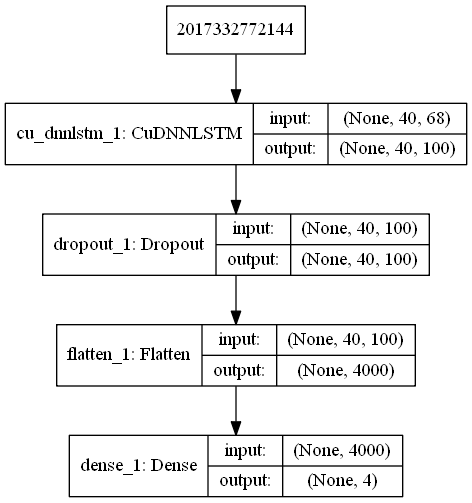

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, 40, 100)           68000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 100)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 16004     
Total params: 84,004
Trainable params: 84,004
Non-trainable params: 0
_________________________________________________________________


In [13]:
# build a default model
model, units = build_student_model(prefix="default")
model.summary()

Although I test multiple model architectures, I'm only going to describe the default architecture here. This architecture has one CuDNNLSTM layer of 100 units and a dropout layer with a dropout rate of 20%. The remainder of the architecture is as described above.

The model diagram and summary are also presented above. The CuDNNLSTM layer has 68,000 parameters and the dense layer has 16,004 parameters; the remaining layers have 0 parameters. In total, the default model has 84,004 parameters, all of which are trainable.

# Step 3: Design validation-based training code

Modify the provided training code to enable examining additional information per epoch such as training loss and accuracy and validation loss and accuracy. You may want to implement early stopping based on the validation set; however, since you will be training 1 epoch at a time, you could also just take performance measurements after each training epoch. If you are making decisions using the validation data (i.e., early stopping), remember to not use the same data to also evaluate the model’s performance. Include code to capture the validation performance so that it can be plotted (in a later HW step).

In [14]:
def train_model(model, units, train_x, train_y, val_x=None, val_y=None, epochs=2,
                seq_length=40, save_models=False, prefix=None):
    # we'll need these
    losses = np.zeros(epochs)
    accs = np.zeros(epochs)
    val_losses = np.zeros(epochs)
    val_accs = np.zeros(epochs)
    
    # file prefix
    prefix = prefix if prefix is not None else "LSTM_" + "_".join([str(u) for u in units])
    
    for i in range(epochs):
        print("-" * 100)
        print("Epoch #{}/{}\n".format(i + 1, epochs))
        
        # train the model
        history = None
        if val_x is None:
            history = model.fit(train_x, train_y, batch_size=128, epochs=1, verbose=1)
        else:
            history = model.fit(train_x, train_y, validation_data=(val_x, val_y), batch_size=128, epochs=1, verbose=1)
            
        # idk, some kind of bug
        sleep(0.1)
        
        # save this iteration of the model if we so desire
        if save_models:
            save_dir = os.path.join(os.getcwd(), "saved-models")
            filename = prefix + "_epoch_" + str(i + 1) + ".h5"
            save_model(model=model, save_dir=save_dir, model_file_name=filename)
        
        # save validation performance
        losses[i] = history.history["loss"][0]
        accs[i] = history.history["acc"][0]
        
        if val_x is not None:
            val_losses[i] = history.history["val_loss"][0]
            val_accs[i] = history.history["val_acc"][0]
        
        # output training/validation loss/accuracy
        print("\nLoss            : {},\taccuracy            : {}".format(losses[i], accs[i]))
        
        if val_x is not None:
            print("Validation loss : {},\tvalidation accuracy : {}\n".format(val_losses[i], val_accs[i]))
    
    # graph the history plots
    graph_history(losses, accs, val_losses, val_accs, plot_val=(val_x is not None), prefix=prefix)
    
    return model

# Step 4: Design testing code

The testing code provided in the HW is designed for the original Karpathy task. Your testing code should have the signature test_model(model, observations, targets) and it should return a sklearn confusion matrix (cm).  ```observations``` is an arbitrary-sized list of 40-character sequences to classify, and ```targets``` is a list of the correct classes of those sequences. A code shell for this function has been provided – but you will need to populate it with working code.

In [15]:
def test_model(model, observations, targets):
    results = model.evaluate(observations, targets)
    predicted = [np.argmax(i) for i in targets]
    actual = model.predict_classes(observations)
   
    return results, predicted, actual, confusion_matrix(predicted, actual)

# Step 5: Conduct a training check on the new architecture

Note that this classification task may not take as many training epochs as past HW assignments have taken – but each epoch may take longer to train than in previous assignments. You may experience that overfitting begins earlier than in previous assignments. Train your new Keras model for 2 epochs. Confirm that training works (training loss is lower in the second epoch) and track how long training takes. You may need to adjust your model architecture based on the expected training time for 20 epochs (don’t build something that you don’t have time to train). Report the estimated time for training 20 epochs.

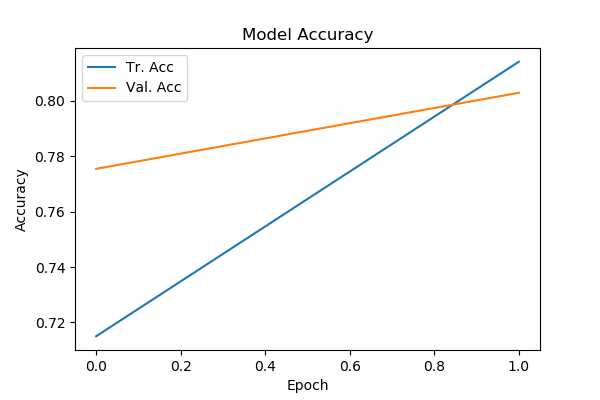

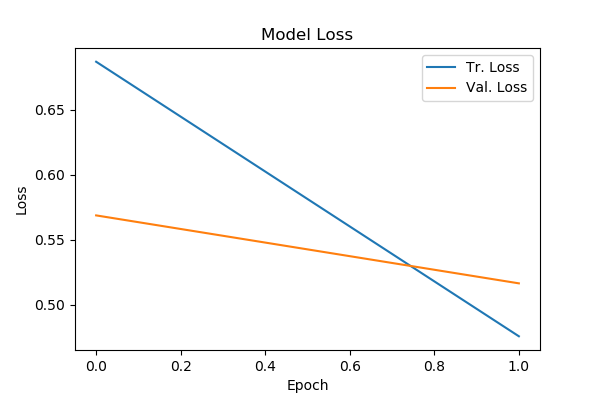

,LSTM Units,Best Epoch,Val Loss,Val Accuracy,Time Per Epoch (seconds),Time to Best Epoch (minutes),Time to Twenty Epochs (minutes)
0,10,10,0.6033,0.7578,85,14.17,28.33
1,50,5,0.5176,0.8028,94,7.83,31.33
2,100,2,0.5174,0.8029,111,3.70,37.00
3,"50, 100",3,0.5043,0.8106,153,7.65,51.00
4,"100, 200",2,0.5216,0.8064,228,7.60,76.00
5,"50, 100, 200",3,0.5245,0.8065,268,13.40,89.33


In [16]:
# train the default model built in Step 1b
if TEST_STUDENT_ARCHITECTURE:
    train_model(model, units, train_x, train_y, val_x=val_x, val_y=val_y, prefix="default")

# display model performance
else:
    filebase = os.path.join(os.getcwd(), "model-performance", "default_")
    display(Image(filename=(filebase + "history_accuracy.png"), width=400))
    display(Image(filename=(filebase + "history_loss.png"), width=400)) 
    display(pd.read_csv(os.path.join(os.getcwd(), "training-stats.csv")))

The plots above show that the model successfully trains for two epochs. The training and validation set accuracy values increase and the losses decrease, just as we expect.

The table above presents some of the training stats generated in Step 6. The table is displayed here to illustrate the range of times to train one epoch. For the smallest model tested, each epoch requires 85 seconds, so training 20 epochs requires 28.33 minutes. For the largest model tested, each epoch requires 268 seconds, so training 20 epochs requires 89.33 minutes.

*I initially tested a few larger models. Specifically, I tested a model with one LSTM layer of 250 units, a model with one LSTM layer of 500 units, a model with LSTM layers of 250 and 500 units, and a model with LSTM layers of 100, 250, and 500 units. Ultimately, I decided not to keep those models in this notebook because they took to long to retrain (and I did retrain all of my models), and they didn't really give increased performance.*

# Step 6: Train the new architecture

Train your network incrementally by epoch, monitoring both training and validation loss and accuracy. Your goal is to design a network which could achieve a training accuracy of 100% and as high validation accuracy as possible. Since you are saving each epoch’s model, you can backtrack to the model that achieves the highest validation accuracy for use in test. In this way, you sidestep the danger of early stopping too early. Plot training and validation curves as you go and use them to help you decide whether to stop training, keep training, or go back and redesign your network.
- If your network training accuracy has not yet plateaued that means you should train for at least another epoch – maybe several more.
- If your network training accuracy plateaus for a few epochs and it is far below 100% accuracy and the loss is still improving, it may mean you just need to train it for more epochs (be patient).  
- If your training loss plateaus then you may need to adjust the optimizer parameters such as learning rate or decay, AND/OR design a different network.  
- Capacity check: Once your training gets close to 100% with loss close to zero, then this means your network has sufficient capacity to learn the task and you are on your way to overfitting. You are unlikely to be improving validation metrics if you keep training. Note that dropout may disturb this type of capacity-check – dropout may prevent training performance from ever getting much better than validation performance.

Your network still may not perform well in generalization (validation accuracy and loss) even if it has good training performance. Don’t get too hung up on trying to get great validation accuracy – if you are above 50% accuracy for a 4-class classification problem, you are doing decently better than chance. Provide plots of training and validation loss and accuracy and describe what happened in your decision-making process (especially if you decided to re-design your network). Consult Chapter 11 in the deep learning book for additional guidance.

---

As described in Step 1a, `build_student_model()` allows for user-level model configuration. For this reason, I loop over several configurations and thus train six models in total. This makes it more likely that I identify an ideal model.

File: ./model-performance/LSTM_100_200_confusion_matrix.png


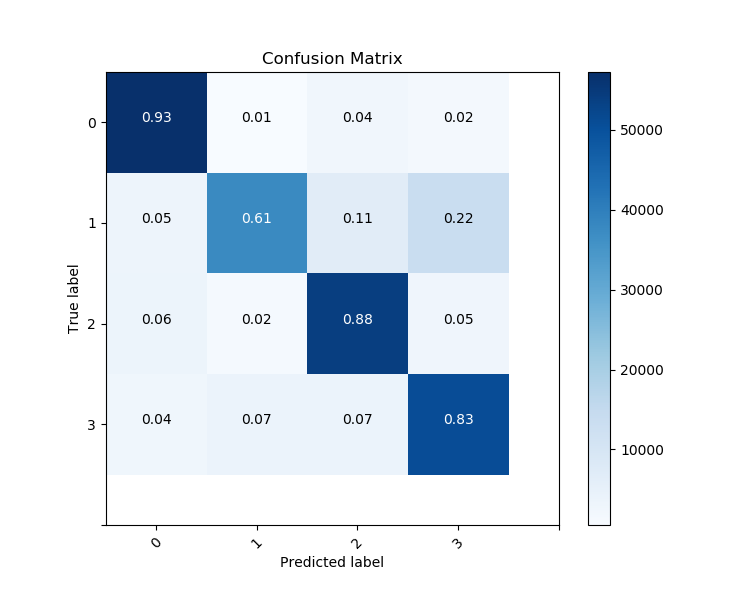

File: ./model-performance/LSTM_100_200_history_accuracy.png


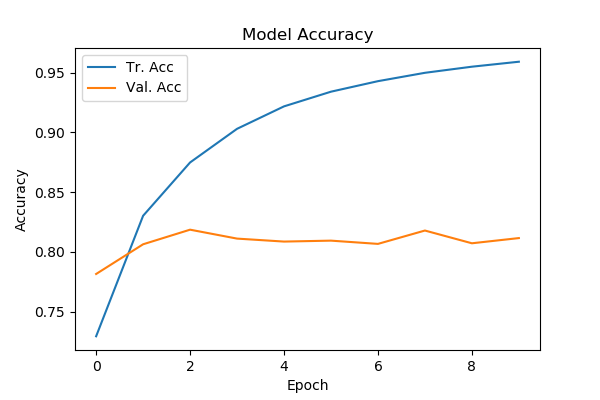

File: ./model-performance/LSTM_100_200_history_loss.png


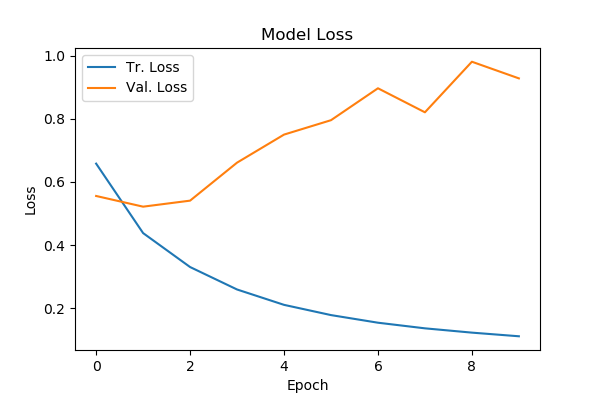

File: ./model-performance/LSTM_100_confusion_matrix.png


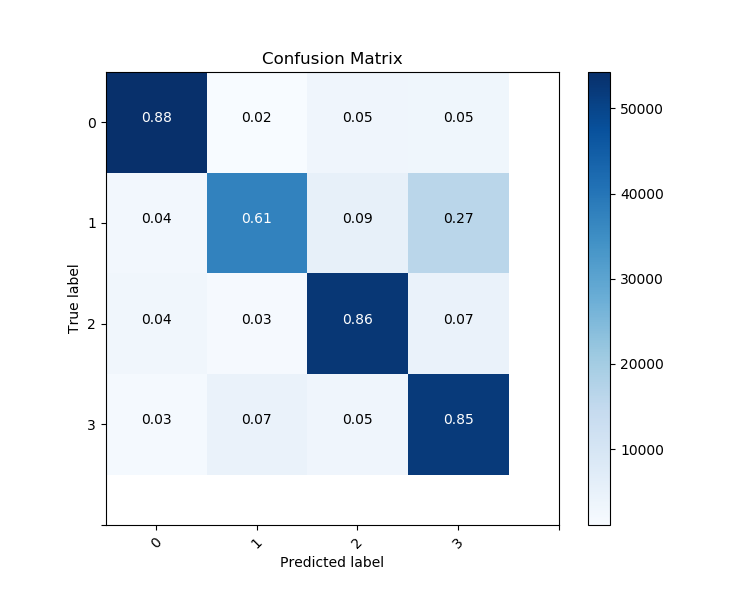

File: ./model-performance/LSTM_100_history_accuracy.png


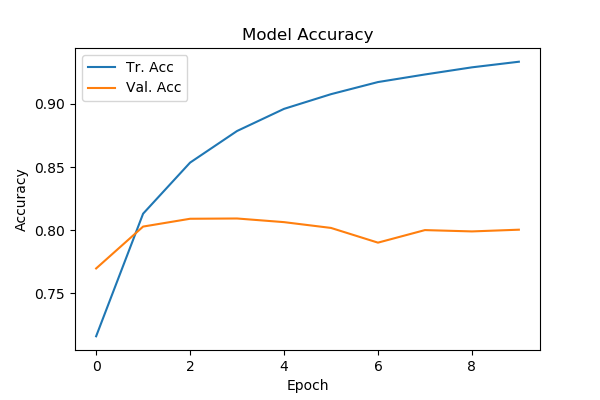

File: ./model-performance/LSTM_100_history_loss.png


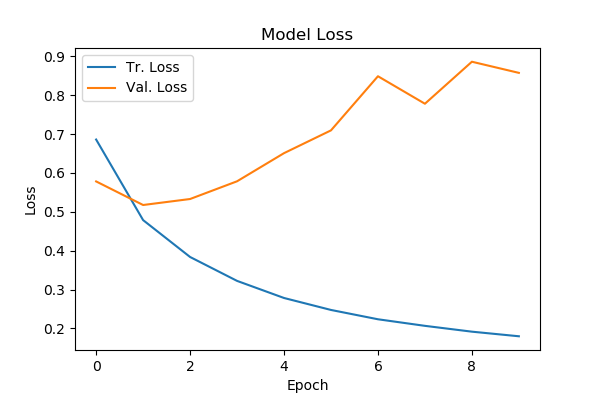

File: ./model-performance/LSTM_10_confusion_matrix.png


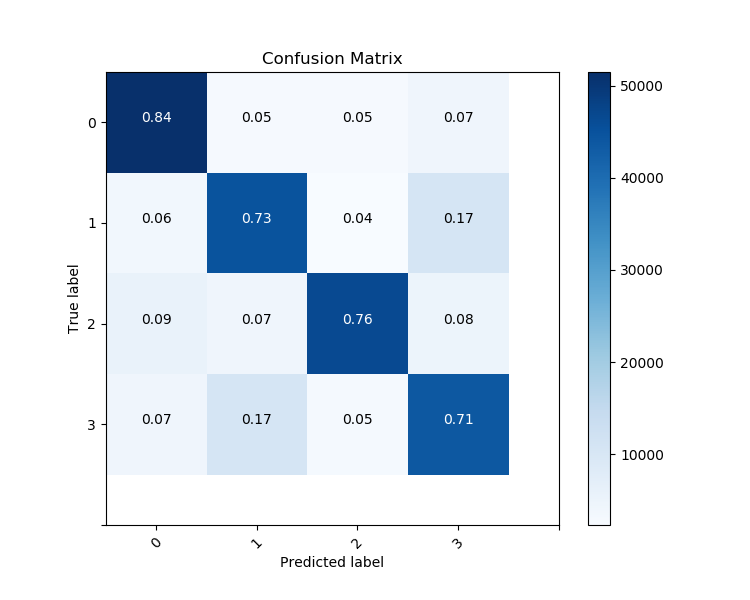

File: ./model-performance/LSTM_10_history_accuracy.png


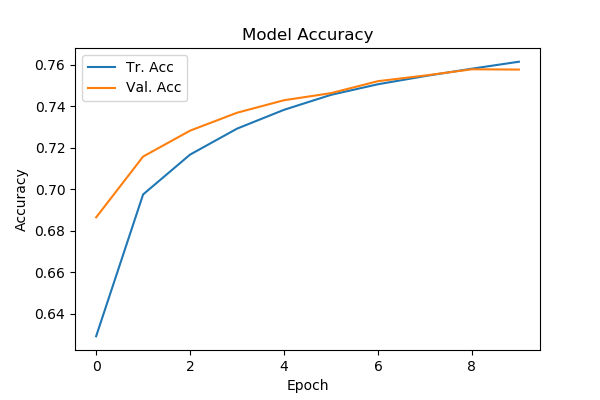

File: ./model-performance/LSTM_10_history_loss.png


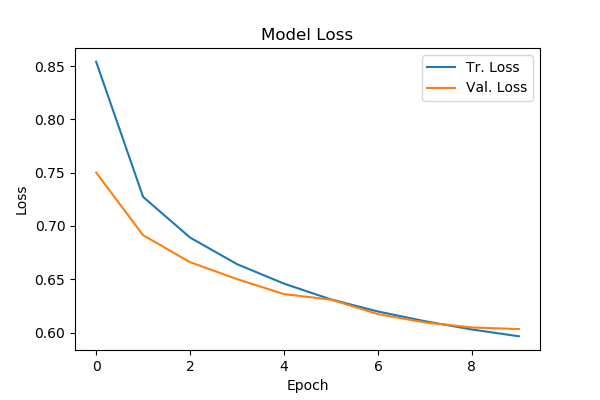

File: ./model-performance/LSTM_50_100_200_confusion_matrix.png


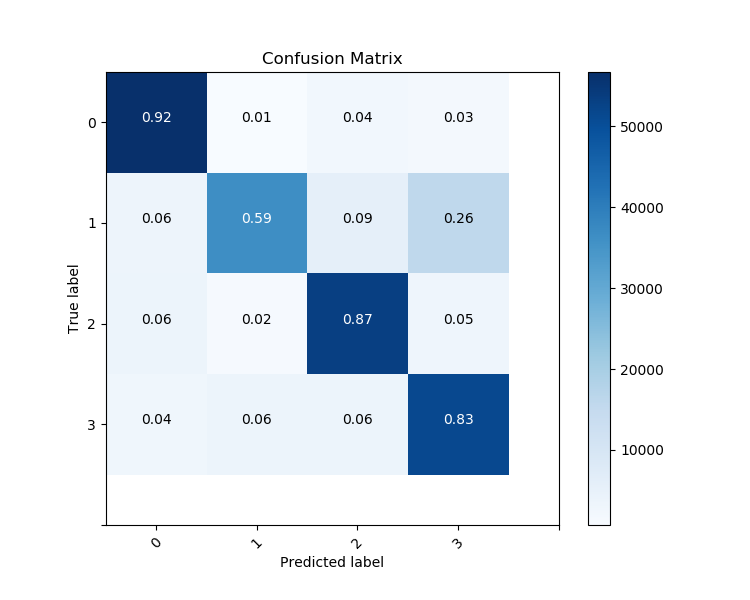

File: ./model-performance/LSTM_50_100_200_history_accuracy.png


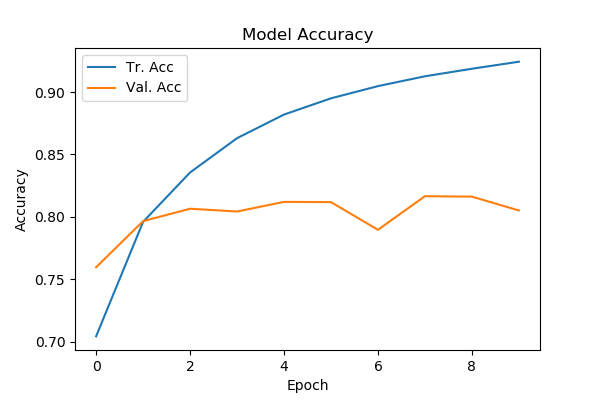

File: ./model-performance/LSTM_50_100_200_history_loss.png


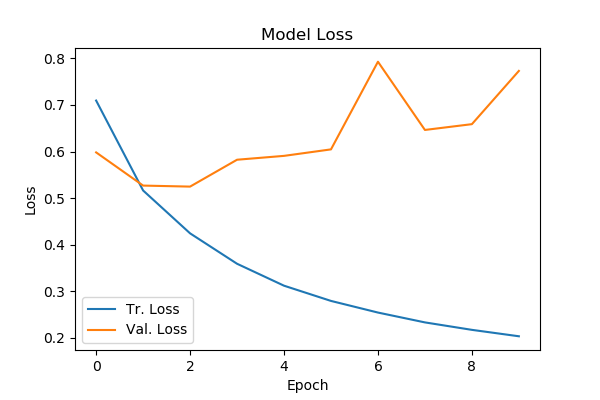

File: ./model-performance/LSTM_50_100_confusion_matrix.png


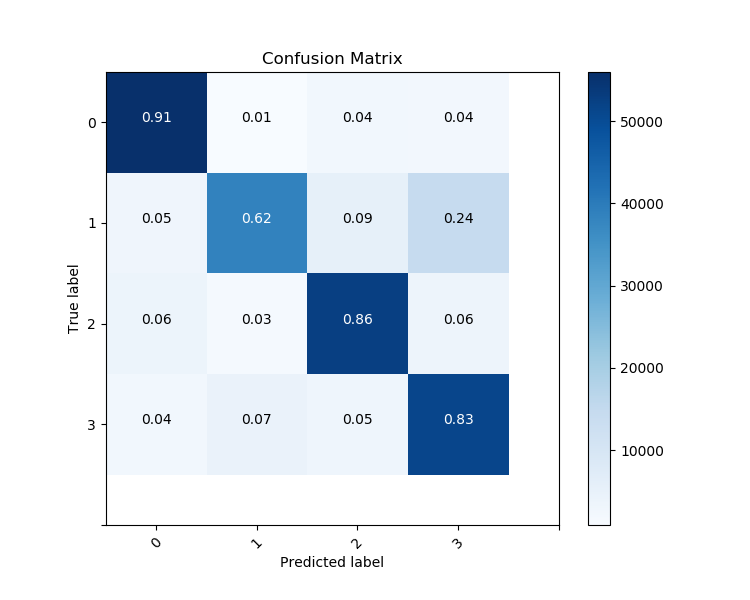

File: ./model-performance/LSTM_50_100_history_accuracy.png


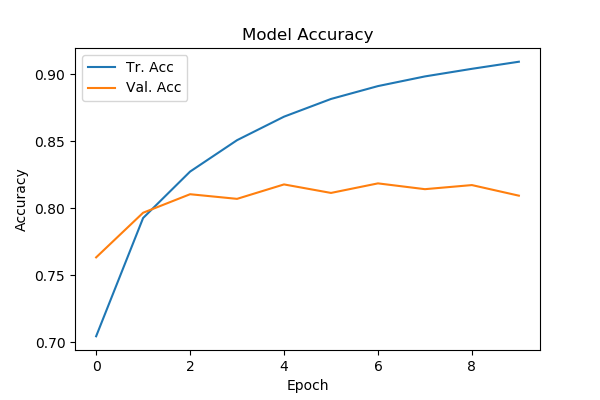

File: ./model-performance/LSTM_50_100_history_loss.png


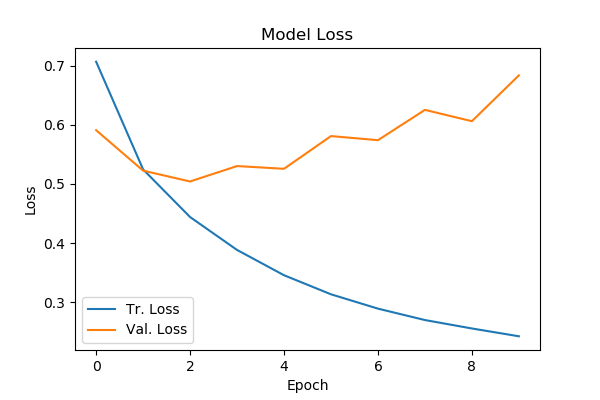

File: ./model-performance/LSTM_50_confusion_matrix.png


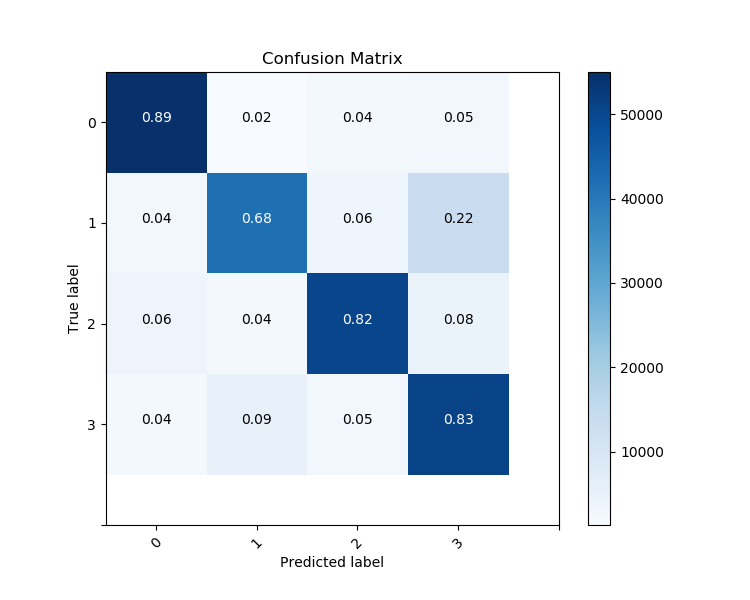

File: ./model-performance/LSTM_50_history_accuracy.png


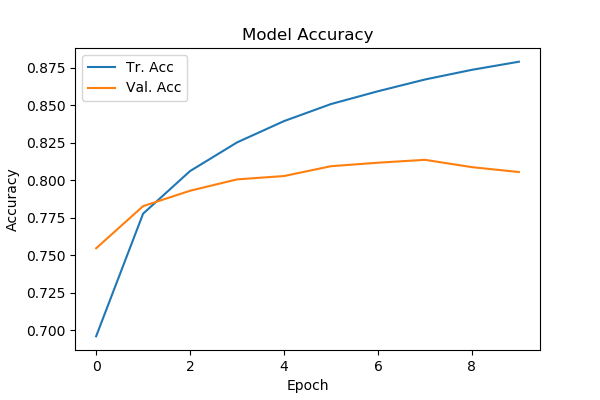

File: ./model-performance/LSTM_50_history_loss.png


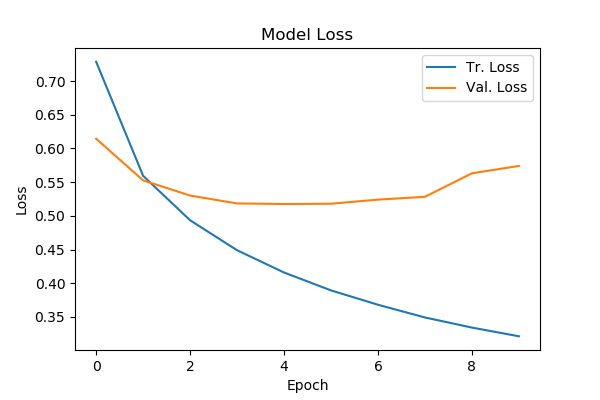

,LSTM Units,Best Epoch,Val Loss,Val Accuracy,Time Per Epoch (seconds),Time to Best Epoch (minutes),Time to Twenty Epochs (minutes)
0,10,10,0.6033,0.7578,85,14.17,28.33
1,50,5,0.5176,0.8028,94,7.83,31.33
2,100,2,0.5174,0.8029,111,3.70,37.00
3,"50, 100",3,0.5043,0.8106,153,7.65,51.00
4,"100, 200",2,0.5216,0.8064,228,7.60,76.00
5,"50, 100, 200",3,0.5245,0.8065,268,13.40,89.33


In [17]:
# train new models
if TEST_STUDENT_ARCHITECTURE:
    # how long does this take?
    start = time.time()
    
    # each of these lists defines a model; some list [a, b, c] represents a model with:
    # an LSTM with <a> nodes, a dropout,
    # an LSTM with <b> nodes, a dropout,
    # an LSTM with <c> nodes, and a dropout
    all_params = [
        [10],
        [50],
        [100],
        [50, 100],
        [100, 200],
        [50, 100, 200],
    ]
    
    # for each model...
    for params in all_params:
        print("=" * 100)
        print("{} LSTM layer node counts: {}".format("=" * 10, ", ".join([str(c) for c in params])))
        print("=" * 100, end="\n\n")
        
        # build and train the model; show performance
        model, units = build_student_model(lstm_units=params)
        model = train_model(model, units, train_x, train_y, val_x=val_x, val_y=val_y, epochs=10)
        results, predicted, actual, cm = test_model(model, test_x, test_y)
        prefix = "LSTM_" + "_".join([str(u) for u in units])
        plot_confusion_matrix(cm, class_labels=np.arange(len(files)), prefix=prefix)
    
    elapsed = time.time() - start
    print("Elapsed time: {:.2f} seconds ({:.2f} hours)".format(elapsed, elapsed / 3600))

# display model performance
else:
    # these diagrams aren't part of this step
    ignore_files = [
        "CROW_DAVID_final_model_confusion_matrix.png", 
        "CROW_DAVID_final_model_history_accuracy.png", 
        "CROW_DAVID_final_model_history_loss.png",
        "default_history_accuracy.png",
        "default_history_loss.png"
    ]
    
    # display each file
    for filename in sorted(os.listdir(os.path.join(os.getcwd(), "model-performance"))):
        if filename not in ignore_files:
            print("File: ./model-performance/{}".format(filename))
            display(Image(filename=os.path.join(os.getcwd(), "model-performance", filename), width=400))

    # overall training stats
    display(pd.read_csv(os.path.join(os.getcwd(), "training-stats.csv")))

The diagrams above show the training results for each model. The table above shows the best validation loss (and its associated accuracy) for each model. The model with two LSTM layers, one of 50 units and the other of 100, has the lowest validation loss overall, and it also has the highest validation accuracy. Clearly, this is the best model of those evaluated.

# Step 7: Evaluate the final architecture's performance

Train your model on all training and validation data. Test your final model on 4-class text data. Capture the predicted AND actual output classes for each input, so you can spot-check them later. Report standard classification metrics (including loss and accuracy) and a confusion matrix. Perform a residuals analysis: investigate some of your network’s mistakes given what you know about the styles of text samples provided. Were they sections of text which were easily misclassified by a human? Give a conjecture about why your network didn’t get them right.

Instructions for updating:
Use tf.cast instead.
Loaded trained model from saved-models\CROW_DAVID_final_model.h5 


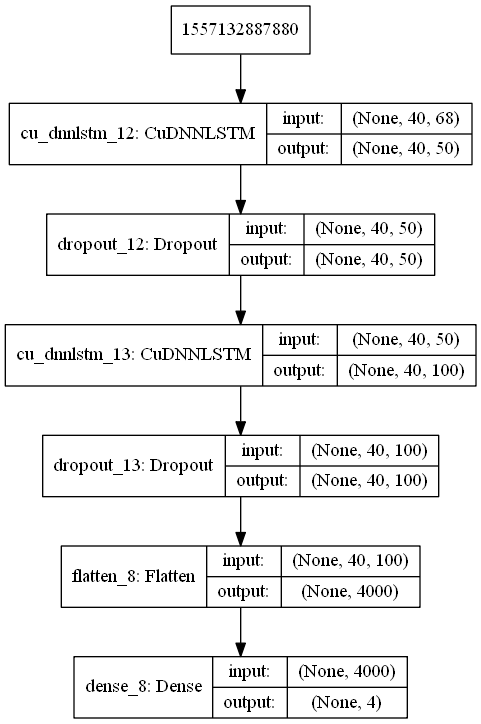

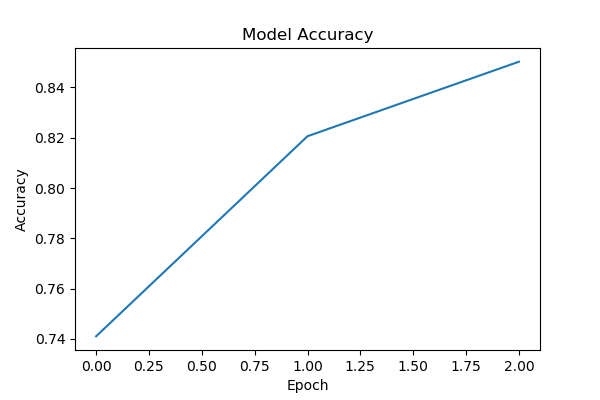

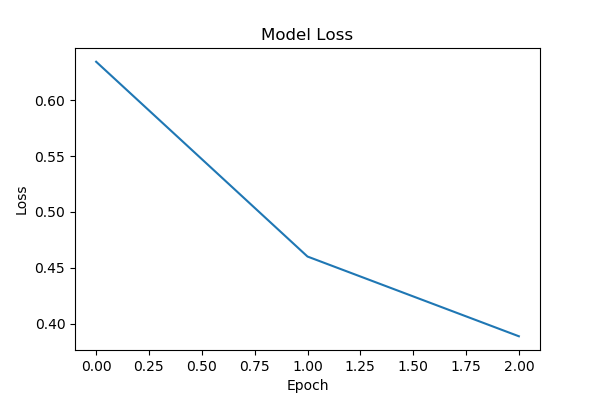

In [18]:
# we'll need these
model = None
cm = None

# train a new model
if TEST_STUDENT_ARCHITECTURE:
    nontest_x = np.concatenate((train_x, val_x))
    nontest_y = np.concatenate((train_y, val_y))
    
    model, units = build_student_model(lstm_units=[50, 100], prefix="CROW_DAVID_final")
    model = train_model(model, units, nontest_x, nontest_y, epochs=3, save_models=True, prefix="CROW_DAVID_final_model")

# load a previous model
else:
    model = load_model(save_dir="saved-models", model_file_name="CROW_DAVID_final_model.h5")
    display(Image(os.path.join(os.getcwd(), "model-diagrams", "CROW_DAVID_final_model_diagram.png")))
        
    # show performance diagrams
    for file in ["history_accuracy", "history_loss"]:
        display(Image(os.path.join(os.getcwd(), "model-performance", "CROW_DAVID_final_model_" + file + ".png"), width=400))

In [19]:
results, predicted, actual, cm = test_model(model, test_x, test_y)

246328/246328 [==============================] - 40s 162us/step


Loss     : 0.4235511976925617
Accuracy : 0.839388944819603


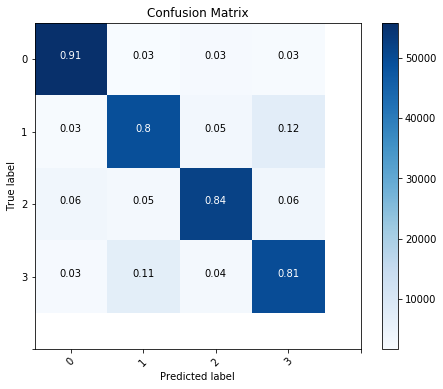

In [20]:
print("Loss     : {}\nAccuracy : {}".format(results[0], results[1]))
plot_confusion_matrix(cm, class_labels=np.arange(len(files)), prefix="CROW_DAVID_final_model")

As stated in Step 6, the best model uses two LSTM layers, one with 50 units and the other with 100. The plots above show the performance of this model after three training epochs (Step 6 shows this to be the ideal number of training epochs for this model).

The model's test set loss is 0.4236; its test set accuracy is 83.94%.

As the confusion matrix shows, the model is best at classifying sequences from the Bible (with 91% classification accuracy). This is expected: many of the 40-character sequences include the number of a Bible verse, so I imagine the model learned to classify sequences that include [number]:[number] as sequences from the Bible.
    
The model most often misclassifies Nietzsche sequences, with sequences from War and Peace as a close second. The confusion matrix shows that, when the model misclassifies a sequence from one of these two texts, it most often predicts that the sequence comes from the other text. This also makes sense: sequences from the Bible usually include some verse number, and sequences from Shakespeare's works usually include a speaker and a colon (e.g., the "All:" in "All: Speak, speak."). Sequences from the other two texts don't often contain unique identifiers like those.

Still, 84% accuracy on a four-class set is nontrivial. A human classifier somewhat familiar with the Bible and with Shakespeare can probably classify most of those sequences correctly, but I doubt that someone who hasn't read Nietzsche or War and Peace can predict classes any better than this model.